# Machine Learning 2 - Final Project

## Learning Team 8 - MSDS PT2025B

* Borromeo, Chloe
* Sison, Florence
* Young, Daniel O.
* Dorado, Joshua Renzo

In [62]:
# Import modules
from sklearn.feature_selection import RFECV

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
plt.rcParams['figure.figsize'] = (8,6)

from collections import Counter
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import time
from sklearn.model_selection import RepeatedKFold, cross_validate, train_test_split
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, roc_auc_score, matthews_corrcoef, classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay

from sklearn.model_selection import cross_val_predict
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.naive_bayes import GaussianNB

from sklearn import metrics
from sklearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV


In [63]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

## A. PREPROCESSING

In [64]:
# Read the Credit Card Balances data

credit_card = (
    pd.read_csv("./data/credit_card_balance.csv")
    # Keep only active contracts and with credit limit for upselling
    .query('NAME_CONTRACT_STATUS == "Active"')
    .sort_values(by=['SK_ID_CURR', 'MONTHS_BALANCE'], ascending=[False, False])
    .drop("NAME_CONTRACT_STATUS", axis=1)
    .set_index('SK_ID_CURR', drop=True)
)

credit_card["AMT_INST_MIN_REGULARITY"] = credit_card["AMT_INST_MIN_REGULARITY"].fillna(0)

credit_card.head()

,SK_ID_PREV,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,...,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,SK_DPD,SK_DPD_DEF
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
456250,1794451,-1,153832.725,175500,0.0,0.0,0.0,0.0,8286.390,9675.0,...,151808.220,153832.725,153832.725,0.0,0,0.0,0.0,10.0,0,0
456250,1794451,-2,158266.935,175500,0.0,0.0,0.0,0.0,8477.730,9675.0,...,156053.160,158266.935,158266.935,0.0,0,0.0,0.0,9.0,0,0
456250,1794451,-3,162425.565,175500,0.0,0.0,0.0,0.0,8643.600,9000.0,...,160554.375,162425.565,162425.565,0.0,0,0.0,0.0,8.0,0,0
456250,1794451,-4,166188.150,180000,0.0,0.0,0.0,0.0,8804.565,9000.0,...,163871.775,166188.150,166188.150,0.0,0,0.0,0.0,7.0,0,0
456250,1794451,-5,169443.855,180000,0.0,0.0,0.0,0.0,8931.420,9000.0,...,167091.345,169443.855,169443.855,0.0,0,0.0,0.0,6.0,0,0


In [65]:
print(credit_card.columns)

Index(['SK_ID_PREV', 'MONTHS_BALANCE', 'AMT_BALANCE',
       'AMT_CREDIT_LIMIT_ACTUAL', 'AMT_DRAWINGS_ATM_CURRENT',
       'AMT_DRAWINGS_CURRENT', 'AMT_DRAWINGS_OTHER_CURRENT',
       'AMT_DRAWINGS_POS_CURRENT', 'AMT_INST_MIN_REGULARITY',
       'AMT_PAYMENT_CURRENT', 'AMT_PAYMENT_TOTAL_CURRENT',
       'AMT_RECEIVABLE_PRINCIPAL', 'AMT_RECIVABLE', 'AMT_TOTAL_RECEIVABLE',
       'CNT_DRAWINGS_ATM_CURRENT', 'CNT_DRAWINGS_CURRENT',
       'CNT_DRAWINGS_OTHER_CURRENT', 'CNT_DRAWINGS_POS_CURRENT',
       'CNT_INSTALMENT_MATURE_CUM', 'SK_DPD', 'SK_DPD_DEF'],
      dtype='object')


In [66]:
df_info = pd.DataFrame()

In [67]:
df_info = df_info = pd.concat([df_info, pd.DataFrame({'df_name': ['credit_card'], 'shape': [credit_card.shape]})], ignore_index=True)

In [68]:
credit_card.index.nunique()

103468

#### A.1. Add new features to the data

With the help of some domain knowledge, we decided to engineer the following features here. 

In [69]:
# Monthly utilization
credit_card["Monthly_Utilization"] = credit_card["AMT_BALANCE"] / \
    credit_card["AMT_CREDIT_LIMIT_ACTUAL"]

# Tag if the customer paid in full
credit_card["Fully_Paid"] = (credit_card["AMT_BALANCE"] == 0)

# Ratio of the payment with the minimum payment
credit_card["Payment_MinPayment_Ratio"] = (
    credit_card['AMT_PAYMENT_TOTAL_CURRENT'] / credit_card['AMT_INST_MIN_REGULARITY']).fillna(0)

# Indicator if a client only paid the minimum amount
credit_card['Paid_Minimum_Only'] = (credit_card['AMT_INST_MIN_REGULARITY'] ==
                                    credit_card['AMT_PAYMENT_TOTAL_CURRENT']) & (credit_card['AMT_INST_MIN_REGULARITY'] > 0)

# Ratio of drawings from 'Other', 'ATM', 'POS' with Total Current Drawings in terms of transaction values
credit_card['AMT_Other_Ratio'] = (credit_card['AMT_DRAWINGS_OTHER_CURRENT'] /
                                  credit_card['AMT_DRAWINGS_CURRENT']).fillna(0)  # Drawings from Other Channels Ratio
credit_card['AMT_ATM_Ratio'] = (credit_card['AMT_DRAWINGS_ATM_CURRENT'] /
                                credit_card['AMT_DRAWINGS_CURRENT']).fillna(0)  # Drawings from ATM Ratio
credit_card['AMT_POS_Ratio'] = (credit_card['AMT_DRAWINGS_POS_CURRENT'] /
                                credit_card['AMT_DRAWINGS_CURRENT']).fillna(0)  # Drawings or usage using POS Terminals

# Ratio of drawings from 'Other', 'ATM', 'POS' with Total Current Drawings in terms of counts

# Count of drawings from Other Channels Ratio
credit_card['CNT_Other_Ratio'] = (
    credit_card['CNT_DRAWINGS_OTHER_CURRENT'] / credit_card['CNT_DRAWINGS_CURRENT']).fillna(0)
credit_card['CNT_ATM_Ratio'] = (credit_card['CNT_DRAWINGS_ATM_CURRENT'] /
                                credit_card['CNT_DRAWINGS_CURRENT']).fillna(0)  # Count of drawings from ATM Ratio

# Count of drawings or usage using POS Terminals
credit_card['CNT_POS_Ratio'] = (
    credit_card['CNT_DRAWINGS_POS_CURRENT'] / credit_card['CNT_DRAWINGS_CURRENT']).fillna(0)

In [70]:
df_info = df_info = pd.concat([df_info, pd.DataFrame({'df_name': ['credit_card after feature'], 'shape': [credit_card.shape]})], ignore_index=True)

#### A.2. Client-Level Aggregations

In [71]:
# Get the latest credit limit 
latest_credit_limits = (
    credit_card
    .sort_values(['MONTHS_BALANCE'])
    .groupby('SK_ID_CURR')
    .last()["AMT_CREDIT_LIMIT_ACTUAL"]
)

# Apply the aggregations
agg_functions = {
    'MONTHS_BALANCE': ['count'],
    'AMT_BALANCE': ['mean'],
    'Monthly_Utilization': ['mean', 'max'],
    'Fully_Paid': ['mean', 'sum'],
    'Paid_Minimum_Only': ['mean', 'sum'],
    'Payment_MinPayment_Ratio': ['mean'],
    'AMT_Other_Ratio': ['mean'],
    'AMT_ATM_Ratio': ['mean'],
    'AMT_POS_Ratio': ['mean'],
    'CNT_Other_Ratio': ['mean'],
    'CNT_ATM_Ratio': ['mean'],
    'CNT_POS_Ratio': ['mean']
}

credit_card_agg = (
    credit_card
    .groupby("SK_ID_CURR")
    .agg(agg_functions)
    .fillna(0)
    .replace([np.inf, -np.inf], 0)
)

# Rename columns
credit_card_agg.columns = [f'{col[0]}_{col[1]}' for col in credit_card_agg.columns]
credit_card_agg = credit_card_agg.rename(columns={
    'MONTHS_BALANCE_count': 'Tenure_Months', 
    'AMT_BALANCE_mean': 'Avg_Monthly_Balance',
    'Monthly_Utilization_mean': 'Avg_Monthly_Utilization',
    'Monthly_Utilization_max': 'Max_Monthly_Utilization',
    'Fully_Paid_mean': 'Pct_Txns_Fully_Paid',
    'Fully_Paid_sum': 'Months_Fully_Paid',
    'Paid_Minimum_Only_mean': 'Pct_Txns_Minimum_Paid',
    'Paid_Minimum_Only_sum': 'Months_Minimum_Paid',
    'AMT_Other_Ratio_mean': 'Avg_AMT_Other_Ratio',
    'AMT_ATM_Ratio_mean': 'Avg_AMT_ATM_Ratio',
    'AMT_POS_Ratio_mean': 'Avg_AMT_POS_Ratio',
    'CNT_Other_Ratio_mean': 'Avg_CNT_Other_Ratio',
    'CNT_ATM_Ratio_mean': 'Avg_CNT_ATM_Ratio',
    'CNT_POS_Ratio_mean': 'Avg_CNT_POS_Ratio'
})

# Incorporate the latest credit limit
credit_card_agg = pd.merge(credit_card_agg, latest_credit_limits,
                           how="inner", 
                           left_index=True, right_index=True)
credit_card_agg.head()


,Tenure_Months,Avg_Monthly_Balance,Avg_Monthly_Utilization,Max_Monthly_Utilization,Pct_Txns_Fully_Paid,Months_Fully_Paid,Pct_Txns_Minimum_Paid,Months_Minimum_Paid,Payment_MinPayment_Ratio_mean,Avg_AMT_Other_Ratio,Avg_AMT_ATM_Ratio,Avg_AMT_POS_Ratio,Avg_CNT_Other_Ratio,Avg_CNT_ATM_Ratio,Avg_CNT_POS_Ratio,AMT_CREDIT_LIMIT_ACTUAL
SK_ID_CURR,,,,,,,,,,,,,,,,
100006,6,0.000000,0.000000,0.00000,1.000000,6,0.000000,0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,270000
100011,74,54482.111149,0.302678,1.05000,0.554054,41,0.418919,31,0.502230,0.0,0.013514,0.0,0.0,0.013514,0.0,90000
100013,96,18159.919219,0.115301,1.02489,0.770833,74,0.000000,0,0.865673,0.0,0.052083,0.0,0.0,0.052083,0.0,45000
100021,7,0.000000,0.000000,0.00000,1.000000,7,0.000000,0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,675000
100023,8,0.000000,0.000000,0.00000,1.000000,8,0.000000,0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,225000


In [72]:
credit_card_agg.index.nunique()

103468

In [73]:
df_info = df_info = pd.concat([df_info, pd.DataFrame({'df_name': ['latest_credit_limits'], 'shape': [latest_credit_limits.shape]})], ignore_index=True)
df_info = df_info = pd.concat([df_info, pd.DataFrame({'df_name': ['credit_card_agg'], 'shape': [credit_card_agg.shape]})], ignore_index=True)
df_info

,df_name,shape
0,credit_card,"(3698436, 21)"
1,credit_card after feature,"(3698436, 31)"
2,latest_credit_limits,"(103468,)"
3,credit_card_agg,"(103468, 16)"


#### A.3. Merge with client-level information (e.g. Demographics and Properties Information)

In [74]:
# Read customer-related data

customer_1 = pd.read_csv("./data/application_train.csv")
customer_2 = pd.read_csv("./data/application_test.csv")

# Concatenate the DataFrames and include all specified columns
customer_info = (
    pd.concat([customer_1, customer_2], axis=0)
    # .set_index("SK_ID_CURR")
    .sort_index()
    [['SK_ID_CURR',  # Customer ID
      'TARGET',  # Tag with late payment
      'CODE_GENDER',  # Gender
      'FLAG_OWN_CAR',  # Owns a car
      'FLAG_OWN_REALTY',  # Owns real property
      'CNT_CHILDREN',  # Number of children
      'AMT_INCOME_TOTAL',  # Total income
      'NAME_INCOME_TYPE',  # Income type
      'NAME_EDUCATION_TYPE',  # Education type
      'NAME_FAMILY_STATUS',  # Family status
      'NAME_HOUSING_TYPE',  # Housing type
      'DAYS_BIRTH',  # Age
      'DAYS_EMPLOYED',  # Employment duration in days
      'OWN_CAR_AGE',  # Age of the car
      'OCCUPATION_TYPE',  # Occupation type
      'CNT_FAM_MEMBERS',  # Number of family members
      'EXT_SOURCE_1',  # External source 1
      'EXT_SOURCE_2',  # External source 2
      'EXT_SOURCE_3'  # External source 3
      ]]
)

# Rename column 'TARGET' with 'W_DEFAULT'
customer_info.rename(columns={'TARGET': 'W_DEFAULT'}, inplace=True)

customer_info.head()  


,SK_ID_CURR,W_DEFAULT,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,OWN_CAR_AGE,OCCUPATION_TYPE,CNT_FAM_MEMBERS,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3
0,100002,1.0,M,N,Y,0,202500.0,Working,Secondary / secondary special,Single / not married,House / apartment,-9461,-637,NaN,Laborers,1.0,0.083037,0.262949,0.139376
0,100001,NaN,F,N,Y,0,135000.0,Working,Higher education,Married,House / apartment,-19241,-2329,NaN,NaN,2.0,0.752614,0.789654,0.159520
1,100005,NaN,M,N,Y,0,99000.0,Working,Secondary / secondary special,Married,House / apartment,-18064,-4469,NaN,Low-skill Laborers,2.0,0.564990,0.291656,0.432962
1,100003,0.0,F,N,N,0,270000.0,State servant,Higher education,Married,House / apartment,-16765,-1188,NaN,Core staff,2.0,0.311267,0.622246,NaN
2,100004,0.0,M,Y,Y,0,67500.0,Working,Secondary / secondary special,Single / not married,House / apartment,-19046,-225,26.0,Laborers,1.0,NaN,0.555912,0.729567


In [75]:
customer_1.columns

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object', length=122)

In [76]:
 customer_1['SK_ID_CURR'].nunique(dropna=False)

307511

In [77]:
 customer_2['SK_ID_CURR'].nunique(dropna=False)

48744

In [78]:
customer_info['SK_ID_CURR'].nunique(dropna=False)

356255

In [79]:
df_info = df_info = pd.concat([df_info, pd.DataFrame({'df_name': ['customer_1 / apptrain'], 'shape': [customer_1.shape]})], ignore_index=True)
df_info = df_info = pd.concat([df_info, pd.DataFrame({'df_name': ['customer_2 / apptest'], 'shape': [customer_2.shape]})], ignore_index=True)
df_info = df_info = pd.concat([df_info, pd.DataFrame({'df_name': ['customer_info'], 'shape': [customer_info.shape]})], ignore_index=True)
df_info

,df_name,shape
0,credit_card,"(3698436, 21)"
1,credit_card after feature,"(3698436, 31)"
2,latest_credit_limits,"(103468,)"
3,credit_card_agg,"(103468, 16)"
4,customer_1 / apptrain,"(307511, 122)"
5,customer_2 / apptest,"(48744, 121)"
6,customer_info,"(356255, 19)"


In [80]:
# Join Credit Card data and Customer Information Dataframes

df_joined = pd.merge(customer_info, credit_card_agg,  how="left", on='SK_ID_CURR')

# Express customer age in years
df_joined["Age_Years"] = abs(df_joined["DAYS_BIRTH"]) / 365

# Express customer age in years
df_joined["Employed_Months"] = abs(df_joined["DAYS_EMPLOYED"]) / 30

# Gender indicator
df_joined["CODE_GENDER_M"] = df_joined['CODE_GENDER'].map({'F': 0, 'M': 1})

# Indicator if client owns a car
df_joined["FLAG_OWN_CAR"] = df_joined['FLAG_OWN_CAR'].map({'Y': 1, 'N': 0})

# Indicator if client owns a real property
df_joined["FLAG_OWN_REALTY"] = df_joined['FLAG_OWN_REALTY'].map({
                                                                'Y': 1, 'N': 0})

# Drop redundant columns
df_joined = df_joined.drop(['CODE_GENDER', 'DAYS_BIRTH'], axis=1)

# Drop rows with no value on any EXT_SOURCE_1, EXT_SOURCE_2, and EXT_SOURCE_3
external_sources = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']
df_joined = df_joined[~df_joined[external_sources].isna().all(
    axis=1)]  # Only one row has none of all

# Create new columns to reflect best and worst scores from EXT_SOURCE_1, EXT_SOURCE_2, and EXT_SOURCE3
df_joined['EXT_SOURCE_best'] = df_joined[external_sources].apply(
    lambda row: row.max(skipna=True), axis=1)
df_joined['EXT_SOURCE_worst'] = df_joined[external_sources].apply(
    lambda row: row.min(skipna=True), axis=1)

# Isolate columns EXT_SOURCE_1, EXT_SOURCE_2, and EXT_SOURCE_3
df_joined = df_joined.drop(columns=external_sources)

# Drop rows with 0 'AMT_CREDIT_LIMIT_ACTUAL' since they cannot be upsold with expanded limit (re-activation would be required instead)
# we do this later
# df_joined = df_joined[df_joined['AMT_CREDIT_LIMIT_ACTUAL'] != 0]

In [81]:
# use mean to fill NA for own car age so that this data can be used without effect for the missing rows
df_joined['OWN_CAR_AGE'].fillna(df_joined.OWN_CAR_AGE.mean(), inplace=True)

# Create new feature credit limit to income ratio
df_joined['credit_limit_income_ratio'] = df_joined['AMT_CREDIT_LIMIT_ACTUAL'] / df_joined['AMT_INCOME_TOTAL']

In [82]:
# na_counts = df_joined['W_DEFAULT'].isna().sum()
# print(f"Number of NA values in W_DEFAULT column: {na_counts}")

df_joined['W_DEFAULT'].fillna(0, inplace=True)
df_joined

,SK_ID_CURR,W_DEFAULT,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,...,Avg_CNT_Other_Ratio,Avg_CNT_ATM_Ratio,Avg_CNT_POS_Ratio,AMT_CREDIT_LIMIT_ACTUAL,Age_Years,Employed_Months,CODE_GENDER_M,EXT_SOURCE_best,EXT_SOURCE_worst,credit_limit_income_ratio
0,100002,1.0,0,1,0,202500.0,Working,Secondary / secondary special,Single / not married,House / apartment,...,NaN,NaN,NaN,NaN,25.920548,21.233333,1.0,0.262949,0.083037,NaN
1,100001,0.0,0,1,0,135000.0,Working,Higher education,Married,House / apartment,...,NaN,NaN,NaN,NaN,52.715068,77.633333,0.0,0.789654,0.159520,NaN
2,100005,0.0,0,1,0,99000.0,Working,Secondary / secondary special,Married,House / apartment,...,NaN,NaN,NaN,NaN,49.490411,148.966667,1.0,0.564990,0.291656,NaN
3,100003,0.0,0,0,0,270000.0,State servant,Higher education,Married,House / apartment,...,NaN,NaN,NaN,NaN,45.931507,39.600000,0.0,0.622246,0.311267,NaN
4,100004,0.0,1,1,0,67500.0,Working,Secondary / secondary special,Single / not married,House / apartment,...,NaN,NaN,NaN,NaN,52.180822,7.500000,1.0,0.729567,0.555912,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356250,456251,0.0,0,0,0,157500.0,Working,Secondary / secondary special,Separated,With parents,...,NaN,NaN,NaN,NaN,25.553425,7.866667,1.0,0.681632,0.145570,NaN
356251,456252,0.0,0,1,0,72000.0,Pensioner,Secondary / secondary special,Widow,House / apartment,...,NaN,NaN,NaN,NaN,56.917808,12174.766667,0.0,0.115992,0.115992,NaN
356252,456253,0.0,0,1,0,153000.0,Working,Higher education,Separated,House / apartment,...,NaN,NaN,NaN,NaN,41.002740,264.033333,0.0,0.744026,0.218859,NaN
356253,456254,1.0,0,1,0,171000.0,Commercial associate,Secondary / secondary special,Married,House / apartment,...,NaN,NaN,NaN,NaN,32.769863,159.533333,0.0,0.661024,0.514163,NaN


In [83]:
df_info = df_info = pd.concat([df_info, pd.DataFrame({'df_name': ['df_joined'], 'shape': [df_joined.shape]})], ignore_index=True)
df_info

,df_name,shape
0,credit_card,"(3698436, 21)"
1,credit_card after feature,"(3698436, 31)"
2,latest_credit_limits,"(103468,)"
3,credit_card_agg,"(103468, 16)"
4,customer_1 / apptrain,"(307511, 122)"
5,customer_2 / apptest,"(48744, 121)"
6,customer_info,"(356255, 19)"
7,df_joined,"(356076, 36)"


#### A.4 Merge with installments data

In [84]:
installments_info = (
    pd.read_csv('./data/installments_payments.csv') 
    .sort_values(by=['SK_ID_CURR', 'NUM_INSTALMENT_NUMBER'], ascending=[False, False])
)

In [85]:
installments_info["LATE_PAYMENT"] = installments_info["DAYS_ENTRY_PAYMENT"] < installments_info["DAYS_INSTALMENT"]
installments_info["LATE_PAYMENT"] = installments_info["LATE_PAYMENT"].astype(int)

installments_info["DAYS_LATE"] = installments_info["DAYS_ENTRY_PAYMENT"] - installments_info["DAYS_INSTALMENT"]
installments_info["DAYS_LATE"] = np.abs(np.where(installments_info["DAYS_LATE"] < 0, installments_info["DAYS_LATE"], 0))

installments_info["AMT_LESS"] = np.abs(np.where(installments_info["AMT_PAYMENT"] < installments_info["AMT_INSTALMENT"], installments_info["AMT_PAYMENT"] - installments_info["AMT_INSTALMENT"], 0))

In [86]:
latest_installment = (
  installments_info
  .sort_values(['SK_ID_CURR', 'NUM_INSTALMENT_NUMBER'])
  .groupby('SK_ID_CURR')
  .last()['SK_ID_PREV']
)
latest_installment.head()
agg_functions = {
    'LATE_PAYMENT': ['sum'],
    'AMT_LESS': ['sum', 'max'],
    'DAYS_LATE': ['mean', 'max']
}

installments_agg = (
  installments_info
  .groupby("SK_ID_CURR")
  .agg(agg_functions)
  .fillna(0)
  .replace([np.inf, -np.inf], 0)
)
installments_agg.columns = [f'{col[0]}_{col[1]}' for col in installments_agg.columns]
installments_agg = installments_agg.rename(columns={
    'LATE_PAYMENT_sum': 'LATE_PAYMENT_DAYS', 
    'AMT_LESS_sum': 'AMT_LESS_TOTAL',
    'AMT_LESS_max': 'AMT_LESS_MAX',
    'DAYS_LATE_mean': 'DAYS_LATE_AVG',
    'DAYS_LATE_max': 'DAYS_LATE_MAX',
})
print(installments_agg.columns)

installments_agg = pd.merge(installments_agg, latest_installment,
                           how="inner", 
                           left_index=True, right_index=True)
installments_agg.head()

Index(['LATE_PAYMENT_DAYS', 'AMT_LESS_TOTAL', 'AMT_LESS_MAX', 'DAYS_LATE_AVG',
       'DAYS_LATE_MAX'],
      dtype='object')


,LATE_PAYMENT_DAYS,AMT_LESS_TOTAL,AMT_LESS_MAX,DAYS_LATE_AVG,DAYS_LATE_MAX,SK_ID_PREV
SK_ID_CURR,,,,,,
100001,4,0.0,0.0,8.857143,36.0,1851984
100002,19,0.0,0.0,20.421053,31.0,1038818
100003,25,0.0,0.0,7.160000,14.0,2396755
100004,3,0.0,0.0,7.666667,11.0,1564014
100005,8,0.0,0.0,23.666667,37.0,2495675


In [87]:
df_joined = pd.merge(df_joined, installments_agg, how='inner', 
                     on='SK_ID_CURR')

df_joined.drop(columns=['SK_ID_PREV'], inplace=True, axis=1)

In [88]:
df_info = df_info = pd.concat([df_info, pd.DataFrame({'df_name': ['installments_info'], 'shape': [installments_info.shape]})], ignore_index=True)
df_info = df_info = pd.concat([df_info, pd.DataFrame({'df_name': ['latest_installment'], 'shape': [latest_installment.shape]})], ignore_index=True)
df_info = df_info = pd.concat([df_info, pd.DataFrame({'df_name': ['installments_agg'], 'shape': [installments_agg.shape]})], ignore_index=True)
df_info = df_info = pd.concat([df_info, pd.DataFrame({'df_name': ['df_joined'], 'shape': [df_joined.shape]})], ignore_index=True)
df_info

,df_name,shape
0,credit_card,"(3698436, 21)"
1,credit_card after feature,"(3698436, 31)"
2,latest_credit_limits,"(103468,)"
3,credit_card_agg,"(103468, 16)"
4,customer_1 / apptrain,"(307511, 122)"
5,customer_2 / apptest,"(48744, 121)"
6,customer_info,"(356255, 19)"
7,df_joined,"(356076, 36)"
8,installments_info,"(13605401, 11)"
9,latest_installment,"(339587,)"


#### A.5 Merge with POS_CASH data

In [89]:
pos_cash = (
    pd.read_csv('./data/POS_CASH_balance.csv') 
    .sort_values(by=['SK_ID_CURR'], ascending=[False])
) 

In [90]:

pos_cash_agg = pos_cash.groupby('SK_ID_CURR')['SK_DPD_DEF'].sum().reset_index()

df_joined = pd.merge(df_joined, pos_cash_agg, how='left', on='SK_ID_CURR')


In [91]:
df_joined['SK_DPD_DEF'].fillna(0, inplace=True)

In [92]:
df_info = df_info = pd.concat([df_info, pd.DataFrame({'df_name': ['pos_cash'], 'shape': [pos_cash.shape]})], ignore_index=True)
df_info = df_info = pd.concat([df_info, pd.DataFrame({'df_name': ['pos_cash_agg'], 'shape': [pos_cash_agg.shape]})], ignore_index=True)
df_info = df_info = pd.concat([df_info, pd.DataFrame({'df_name': ['df_joined'], 'shape': [df_joined.shape]})], ignore_index=True)
df_info

,df_name,shape
0,credit_card,"(3698436, 21)"
1,credit_card after feature,"(3698436, 31)"
2,latest_credit_limits,"(103468,)"
3,credit_card_agg,"(103468, 16)"
4,customer_1 / apptrain,"(307511, 122)"
5,customer_2 / apptest,"(48744, 121)"
6,customer_info,"(356255, 19)"
7,df_joined,"(356076, 36)"
8,installments_info,"(13605401, 11)"
9,latest_installment,"(339587,)"


#### A.6 Merge with previous application data

In [93]:
prev_app_info = (
  pd.read_csv('./data/previous_application.csv')
  .sort_values(by=['SK_ID_CURR'], ascending=[False])
)

In [94]:
prev_app_info['LESS_GRANTED'] = prev_app_info['AMT_APPLICATION'] > prev_app_info['AMT_CREDIT']
prev_app_info['REJECTED'] = prev_app_info['NAME_CONTRACT_STATUS'] == 'Refused'

In [95]:
prev_app_latest = (
  prev_app_info
  .sort_values(['SK_ID_CURR'],ascending=[False])
  .groupby('SK_ID_CURR')
  .last()['NAME_CONTRACT_TYPE']
)

In [96]:
prev_app_agg = (
  prev_app_info
  .groupby('SK_ID_CURR')
  .agg({
      'LESS_GRANTED': ['sum'],
      'REJECTED': ['sum'],
  })
  .fillna(0)
  .replace([np.inf, -np.inf], 0)
)

prev_app_agg.columns = [f'{col[0]}_{col[1]}' for col in prev_app_agg.columns]
prev_app_agg = prev_app_agg.rename(columns={
    'LESS_GRANTED_sum': 'LESS_GRANTED',
    'REJECTED_sum': 'REJECTED_APPLICATIONS'
})
prev_app_agg = pd.merge(prev_app_agg, prev_app_latest, how='inner', left_index=True, right_index=True)
prev_app_agg.drop(columns=['NAME_CONTRACT_TYPE'], inplace=True, axis=1)


In [97]:
df_joined = pd.merge(df_joined, prev_app_agg, how='inner', on='SK_ID_CURR')

In [98]:
df_info = df_info = pd.concat([df_info, pd.DataFrame({'df_name': ['prev_app_info'], 'shape': [prev_app_info.shape]})], ignore_index=True)
df_info = df_info = pd.concat([df_info, pd.DataFrame({'df_name': ['prev_app_agg'], 'shape': [prev_app_agg.shape]})], ignore_index=True)
df_info = df_info = pd.concat([df_info, pd.DataFrame({'df_name': ['df_joined'], 'shape': [df_joined.shape]})], ignore_index=True)
df_info

,df_name,shape
0,credit_card,"(3698436, 21)"
1,credit_card after feature,"(3698436, 31)"
2,latest_credit_limits,"(103468,)"
3,credit_card_agg,"(103468, 16)"
4,customer_1 / apptrain,"(307511, 122)"
5,customer_2 / apptest,"(48744, 121)"
6,customer_info,"(356255, 19)"
7,df_joined,"(356076, 36)"
8,installments_info,"(13605401, 11)"
9,latest_installment,"(339587,)"


#### A.7 Merge with bureau data

In [99]:
bureau_info = (
  pd.read_csv('./data/bureau.csv')
  .sort_values(by=['SK_ID_CURR'], ascending=[False])
)
bureau_info[['AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 
       'AMT_CREDIT_SUM_LIMIT', 'AMT_CREDIT_SUM_OVERDUE']] = bureau_info[['AMT_CREDIT_SUM', 
       'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT', 'AMT_CREDIT_SUM_OVERDUE']].fillna(0)

In [47]:
bureau_info

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
1010009,456255,5126333,Active,currency 1,-363,0,1463.0,NaN,0.000,0,436032.0,363573.54,0.0,0.0,Consumer credit,-25,0.0
1010011,456255,5126335,Closed,currency 1,-1512,0,315.0,-781.0,25578.000,0,900000.0,0.00,0.0,0.0,Consumer credit,-781,0.0
1010003,456255,5126327,Closed,currency 1,-1022,0,-959.0,-958.0,NaN,0,22995.0,0.00,0.0,0.0,Consumer credit,-890,0.0
1010010,456255,5126334,Active,currency 1,-451,0,279.0,NaN,15439.905,0,450000.0,191005.47,0.0,0.0,Consumer credit,-55,3244.5
1010013,456255,5126337,Closed,currency 1,-2337,0,-1243.0,-1621.0,16618.500,0,450000.0,0.00,0.0,0.0,Consumer credit,-1621,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248487,100001,5896633,Closed,currency 1,-1572,0,-1329.0,-1328.0,NaN,0,85500.0,0.00,0.0,0.0,Consumer credit,-155,0.0
248488,100001,5896634,Active,currency 1,-559,0,902.0,NaN,NaN,0,337680.0,113166.00,0.0,0.0,Consumer credit,-6,4630.5
248489,100001,5896635,Active,currency 1,-49,0,1778.0,NaN,NaN,0,378000.0,373239.00,0.0,0.0,Consumer credit,-16,10822.5
248490,100001,5896636,Active,currency 1,-320,0,411.0,NaN,NaN,0,168345.0,110281.50,0.0,0.0,Consumer credit,-10,9364.5


In [48]:
bureau_info['AMT_CREDIT_SUM_DEBT'] = bureau_info['AMT_CREDIT_SUM_DEBT'].fillna(0)
bureau_info['AMT_CREDIT_MAX_OVERDUE'] = bureau_info['AMT_CREDIT_MAX_OVERDUE'].fillna(0)

In [49]:
bureau_latest = (
  bureau_info
  .sort_values(['SK_ID_CURR'],ascending=[False])
  .groupby('SK_ID_CURR')
  .last()['CREDIT_ACTIVE']
)

bureau_agg = (
  bureau_info
  .groupby('SK_ID_CURR')
  .agg({
      'AMT_CREDIT_SUM': ['sum'],
      'AMT_CREDIT_SUM_DEBT': ['sum'],
      'AMT_CREDIT_SUM_LIMIT': ['sum'],
      'AMT_CREDIT_SUM_OVERDUE': ['sum'],
  })
  .fillna(0)
  .replace([np.inf, -np.inf], 0)
)

# Check for columns with missing values
bureau_agg.columns = [f'{col[0]}_{col[1]}' for col in bureau_agg.columns]
bureau_agg = bureau_agg.rename(columns={
    'AMT_CREDIT_SUM_sum': 'AMT_CREDIT_SUM_TOTAL',
    'AMT_CREDIT_SUM_DEBT_sum': 'AMT_CREDIT_SUM_DEBT_TOTAL',
    'AMT_CREDIT_SUM_LIMIT_sum': 'AMT_CREDIT_SUM_LIMIT_TOTAL',
    'AMT_CREDIT_SUM_OVERDUE_sum': 'AMT_CREDIT_SUM_OVERDUE_TOTAL',
})

# bureau_agg.drop(columns=['CREDIT_ACTIVE'], inplace=True, axis=1)
bureau_agg[['AMT_CREDIT_SUM_TOTAL', 'AMT_CREDIT_SUM_DEBT_TOTAL', 
            'AMT_CREDIT_SUM_LIMIT_TOTAL', 'AMT_CREDIT_SUM_OVERDUE_TOTAL']] = bureau_agg[['AMT_CREDIT_SUM_TOTAL', 
            'AMT_CREDIT_SUM_DEBT_TOTAL', 'AMT_CREDIT_SUM_LIMIT_TOTAL', 'AMT_CREDIT_SUM_OVERDUE_TOTAL']].fillna(0)

# Check for columns with missing values

In [50]:
df_joined = pd.merge(df_joined, bureau_agg, how='inner', on='SK_ID_CURR')

In [51]:
#df_joined['debt_to_income_ratio'] = df_joined['AMT_CREDIT_SUM_DEBT_TOTAL'] / df_joined['AMT_INCOME_TOTAL']
#df_joined['credit_utilization_ratio'] = df_joined['AMT_CREDIT_SUM_DEBT_TOTAL'] / df_joined['AMT_CREDIT_SUM_LIMIT_TOTAL']
#df_joined['income_per_family_member'] = df_joined['AMT_INCOME_TOTAL'] / df_joined['CNT_FAM_MEMBERS']

In [52]:
# Check for columns with missing values
na_columns = df_joined.columns[df_joined.isna().any()].tolist()
print("Columns with missing values:", na_columns)

Columns with missing values: ['OCCUPATION_TYPE', 'Tenure_Months', 'Avg_Monthly_Balance', 'Avg_Monthly_Utilization', 'Max_Monthly_Utilization', 'Pct_Txns_Fully_Paid', 'Months_Fully_Paid', 'Pct_Txns_Minimum_Paid', 'Months_Minimum_Paid', 'Payment_MinPayment_Ratio_mean', 'Avg_AMT_Other_Ratio', 'Avg_AMT_ATM_Ratio', 'Avg_AMT_POS_Ratio', 'Avg_CNT_Other_Ratio', 'Avg_CNT_ATM_Ratio', 'Avg_CNT_POS_Ratio', 'AMT_CREDIT_LIMIT_ACTUAL', 'CODE_GENDER_M', 'credit_limit_income_ratio']


In [53]:
minority_ratio = df_joined['W_DEFAULT'].value_counts()[1] / \
    df_joined['W_DEFAULT'].value_counts()[0]

print(f"Ratio of minority class to majority: {minority_ratio:.2f}")

Ratio of minority class to majority: 0.07


<Axes: xlabel='W_DEFAULT', ylabel='count'>

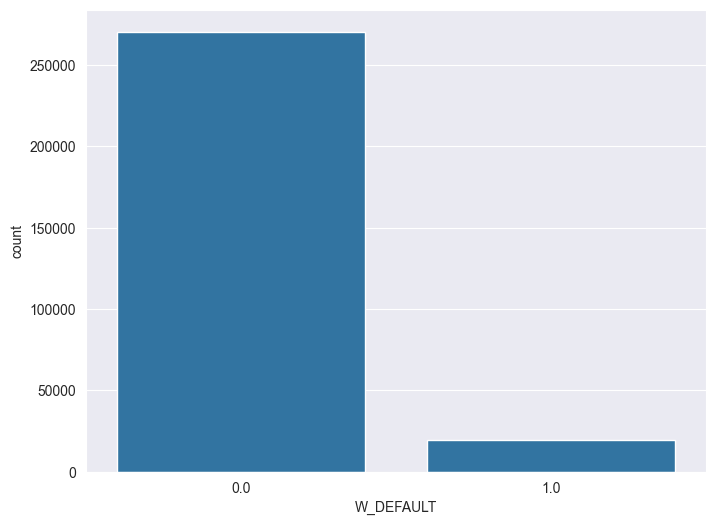

In [54]:
sns.countplot(data = df_joined, x = 'W_DEFAULT')

In [55]:
df_joined.head()

,SK_ID_CURR,W_DEFAULT,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,...,AMT_LESS_MAX,DAYS_LATE_AVG,DAYS_LATE_MAX,SK_DPD_DEF,LESS_GRANTED,REJECTED_APPLICATIONS,AMT_CREDIT_SUM_TOTAL,AMT_CREDIT_SUM_DEBT_TOTAL,AMT_CREDIT_SUM_LIMIT_TOTAL,AMT_CREDIT_SUM_OVERDUE_TOTAL
0,100002,1.0,0,1,0,202500.0,Working,Secondary / secondary special,Single / not married,House / apartment,...,0.0,20.421053,31.0,0.0,0,0,865055.565,245781.0,31988.565,0.0
1,100001,0.0,0,1,0,135000.0,Working,Higher education,Married,House / apartment,...,0.0,8.857143,36.0,7.0,1,0,1453365.000,596686.5,0.000,0.0
2,100005,0.0,0,1,0,99000.0,Working,Secondary / secondary special,Married,House / apartment,...,0.0,23.666667,37.0,0.0,1,0,657126.000,568408.5,0.000,0.0
3,100003,0.0,0,0,0,270000.0,State servant,Higher education,Married,House / apartment,...,0.0,7.160000,14.0,0.0,1,0,1017400.500,0.0,810000.000,0.0
4,100004,0.0,1,1,0,67500.0,Working,Secondary / secondary special,Single / not married,House / apartment,...,0.0,7.666667,11.0,0.0,1,0,189037.800,0.0,0.000,0.0


In [56]:
df_info = df_info = pd.concat([df_info, pd.DataFrame({'df_name': ['bureau_info'], 'shape': [bureau_info.shape]})], ignore_index=True)
df_info = df_info = pd.concat([df_info, pd.DataFrame({'df_name': ['bureau_latest'], 'shape': [bureau_latest.shape]})], ignore_index=True)
df_info = df_info = pd.concat([df_info, pd.DataFrame({'df_name': ['bureau_agg'], 'shape': [bureau_agg.shape]})], ignore_index=True)
df_info = df_info = pd.concat([df_info, pd.DataFrame({'df_name': ['df_joined'], 'shape': [df_joined.shape]})], ignore_index=True)
df_info

,df_name,shape
0,credit_card,"(3698436, 21)"
1,credit_card after feature,"(3698436, 31)"
2,latest_credit_limits,"(103468,)"
3,credit_card_agg,"(103468, 16)"
4,customer_1 / apptrain,"(307511, 122)"
5,customer_2 / apptest,"(48744, 121)"
6,customer_info,"(356255, 19)"
7,df_joined,"(356076, 36)"
8,installments_info,"(13605401, 11)"
9,latest_installment,"(339587,)"


In [57]:
# One-hot encode the specified columns
columns_to_encode = ['NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE']
df_joined = pd.get_dummies(df_joined, columns=columns_to_encode, prefix=columns_to_encode, dtype=int)

print(df_joined.columns)


Index(['SK_ID_CURR', 'W_DEFAULT', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'DAYS_EMPLOYED', 'OWN_CAR_AGE',
       'CNT_FAM_MEMBERS', 'Tenure_Months', 'Avg_Monthly_Balance',
       'Avg_Monthly_Utilization', 'Max_Monthly_Utilization',
       'Pct_Txns_Fully_Paid', 'Months_Fully_Paid', 'Pct_Txns_Minimum_Paid',
       'Months_Minimum_Paid', 'Payment_MinPayment_Ratio_mean',
       'Avg_AMT_Other_Ratio', 'Avg_AMT_ATM_Ratio', 'Avg_AMT_POS_Ratio',
       'Avg_CNT_Other_Ratio', 'Avg_CNT_ATM_Ratio', 'Avg_CNT_POS_Ratio',
       'AMT_CREDIT_LIMIT_ACTUAL', 'Age_Years', 'Employed_Months',
       'CODE_GENDER_M', 'EXT_SOURCE_best', 'EXT_SOURCE_worst',
       'credit_limit_income_ratio', 'LATE_PAYMENT_DAYS', 'AMT_LESS_TOTAL',
       'AMT_LESS_MAX', 'DAYS_LATE_AVG', 'DAYS_LATE_MAX', 'SK_DPD_DEF',
       'LESS_GRANTED', 'REJECTED_APPLICATIONS', 'AMT_CREDIT_SUM_TOTAL',
       'AMT_CREDIT_SUM_DEBT_TOTAL', 'AMT_CREDIT_SUM_LIMIT_TOTAL',
       'AMT_CREDIT_SUM_OVERDUE_TO

In [58]:
df_info = df_info = pd.concat([df_info, pd.DataFrame({'df_name': ['df_joined after onehot encoding'], 'shape': [df_joined.shape]})], ignore_index=True)
df_info

,df_name,shape
0,credit_card,"(3698436, 21)"
1,credit_card after feature,"(3698436, 31)"
2,latest_credit_limits,"(103468,)"
3,credit_card_agg,"(103468, 16)"
4,customer_1 / apptrain,"(307511, 122)"
5,customer_2 / apptest,"(48744, 121)"
6,customer_info,"(356255, 19)"
7,df_joined,"(356076, 36)"
8,installments_info,"(13605401, 11)"
9,latest_installment,"(339587,)"


In [59]:
from imblearn.over_sampling import ADASYN
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler

# Initialize the scaler
scaler = MinMaxScaler()
df_joined[['Avg_Monthly_Balance','Months_Fully_Paid', 
           'Months_Minimum_Paid', 'Months_Minimum_Paid', 
           'AMT_INCOME_TOTAL', 'DAYS_EMPLOYED', 'OWN_CAR_AGE',
           'Age_Years','Employed_Months', 'AMT_LESS_TOTAL',
           'AMT_LESS_MAX', 'DAYS_LATE_MAX', 'SK_DPD_DEF',
           'AMT_CREDIT_SUM_TOTAL', 'AMT_CREDIT_SUM_DEBT_TOTAL',
           'AMT_CREDIT_SUM_LIMIT_TOTAL', 'AMT_CREDIT_SUM_OVERDUE_TOTAL','Tenure_Months']] = scaler.fit_transform(df_joined[['Avg_Monthly_Balance','Months_Fully_Paid', 
           'Months_Minimum_Paid', 'Months_Minimum_Paid', 
           'AMT_INCOME_TOTAL', 'DAYS_EMPLOYED', 'OWN_CAR_AGE',
           'Age_Years','Employed_Months', 'AMT_LESS_TOTAL',
           'AMT_LESS_MAX', 'DAYS_LATE_MAX', 'SK_DPD_DEF',
           'AMT_CREDIT_SUM_TOTAL', 'AMT_CREDIT_SUM_DEBT_TOTAL',
           'AMT_CREDIT_SUM_LIMIT_TOTAL', 'AMT_CREDIT_SUM_OVERDUE_TOTAL','Tenure_Months']])

# Convert non-numeric columns later to flatten
X = df_joined.drop(columns=['W_DEFAULT'])
y = df_joined['W_DEFAULT']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [60]:
df_info = df_info = pd.concat([df_info, pd.DataFrame({'df_name': ['df_joined after scaler'], 'shape': [df_joined.shape]})], ignore_index=True)
df_info

,df_name,shape
0,credit_card,"(3698436, 21)"
1,credit_card after feature,"(3698436, 31)"
2,latest_credit_limits,"(103468,)"
3,credit_card_agg,"(103468, 16)"
4,customer_1 / apptrain,"(307511, 122)"
5,customer_2 / apptest,"(48744, 121)"
6,customer_info,"(356255, 19)"
7,df_joined,"(356076, 36)"
8,installments_info,"(13605401, 11)"
9,latest_installment,"(339587,)"


In [61]:
adasyn = ADASYN(sampling_strategy='minority', random_state=42, n_neighbors=5)
X_res, y_res = adasyn.fit_resample(X_train, y_train)

# Combine the resampled features and target variable into a single DataFrame
df_adasyn = pd.concat([X_res, y_res], axis=1)

df_adasyn.head()


ValueError: Input X contains NaN.
ADASYN does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

Ratio of minority class to majority: 1.00


Text(0.5, 1.0, 'ADASYN Balanced')

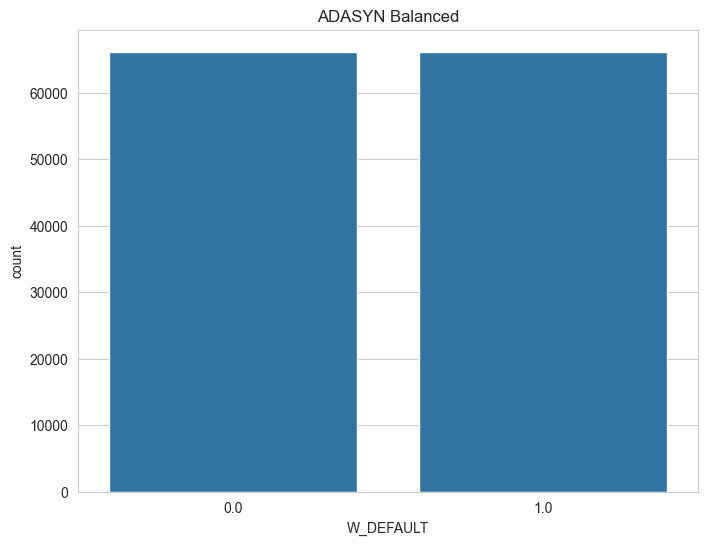

In [207]:
minority_ratio = df_adasyn['W_DEFAULT'].value_counts()[1] / \
    df_adasyn['W_DEFAULT'].value_counts()[0]

print(f"Ratio of minority class to majority: {minority_ratio:.2f}")

sns.countplot(data=df_adasyn, x='W_DEFAULT').set_title('ADASYN Balanced')

In [208]:
df_joined.columns

Index(['SK_ID_CURR', 'Tenure_Months', 'Avg_Monthly_Balance',
       'Avg_Monthly_Utilization', 'Max_Monthly_Utilization',
       'Pct_Txns_Fully_Paid', 'Months_Fully_Paid', 'Pct_Txns_Minimum_Paid',
       'Months_Minimum_Paid', 'Payment_MinPayment_Ratio_mean',
       'Avg_AMT_Other_Ratio', 'Avg_AMT_ATM_Ratio', 'Avg_AMT_POS_Ratio',
       'Avg_CNT_Other_Ratio', 'Avg_CNT_ATM_Ratio', 'Avg_CNT_POS_Ratio',
       'AMT_CREDIT_LIMIT_ACTUAL', 'W_DEFAULT', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'DAYS_EMPLOYED',
       'OWN_CAR_AGE', 'CNT_FAM_MEMBERS', 'Age_Years', 'Employed_Months',
       'CODE_GENDER_M', 'EXT_SOURCE_best', 'EXT_SOURCE_worst',
       'credit_limit_income_ratio', 'LATE_PAYMENT_DAYS', 'AMT_LESS_TOTAL',
       'AMT_LESS_MAX', 'DAYS_LATE_AVG', 'DAYS_LATE_MAX', 'SK_DPD_DEF',
       'LESS_GRANTED', 'REJECTED_APPLICATIONS', 'AMT_CREDIT_SUM_TOTAL',
       'AMT_CREDIT_SUM_DEBT_TOTAL', 'AMT_CREDIT_SUM_LIMIT_TOTAL',
       'AMT_CREDIT_SUM_OVERDUE_TO

In [209]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='minority', random_state=42)
X_res_smote, y_res_smote = smote.fit_resample(X_train, y_train)

# Combine the resampled features and target variable into a single DataFrame
df_smote = pd.concat([X_res_smote, y_res_smote], axis=1)

df_smote.head()

,SK_ID_CURR,Tenure_Months,Avg_Monthly_Balance,Avg_Monthly_Utilization,Max_Monthly_Utilization,Pct_Txns_Fully_Paid,Months_Fully_Paid,Pct_Txns_Minimum_Paid,Months_Minimum_Paid,Payment_MinPayment_Ratio_mean,...,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,W_DEFAULT
0,344496,0.112994,0.003467,0.000000,0.000000,1.000000,0.142857,0.000000,0.000000,0.0,...,0,0,0,1,0,0,0,0,0,0.0
1,228692,0.045198,0.083030,0.676647,1.038296,0.111111,0.006803,0.000000,0.000000,0.0,...,0,0,0,0,0,0,0,0,0,0.0
2,281930,0.141243,0.087547,0.302559,0.878619,0.307692,0.054422,0.000000,0.000000,0.0,...,0,0,0,0,0,1,0,0,0,0.0
3,298803,0.022599,0.103580,0.460726,0.916242,0.000000,0.000000,0.200000,0.010417,0.0,...,0,0,0,0,0,0,0,0,0,1.0
4,450479,0.412429,0.006406,0.020289,0.311094,0.878378,0.442177,0.027027,0.020833,0.0,...,0,0,0,0,0,1,0,0,0,0.0


Ratio of minority class to majority: 1.00


Text(0.5, 1.0, 'SMOTE Balanced')

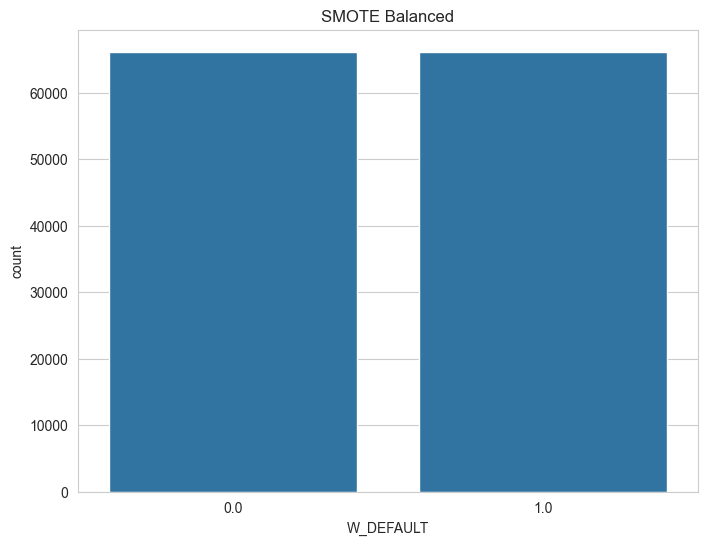

In [210]:
minority_ratio = df_smote['W_DEFAULT'].value_counts()[1] / \
    df_smote['W_DEFAULT'].value_counts()[0]

print(f"Ratio of minority class to majority: {minority_ratio:.2f}")

sns.countplot(data = df_smote, x = 'W_DEFAULT').set_title('SMOTE Balanced')

In [211]:
df_joined

,SK_ID_CURR,Tenure_Months,Avg_Monthly_Balance,Avg_Monthly_Utilization,Max_Monthly_Utilization,Pct_Txns_Fully_Paid,Months_Fully_Paid,Pct_Txns_Minimum_Paid,Months_Minimum_Paid,Payment_MinPayment_Ratio_mean,...,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff
0,100011,0.412429,0.061929,0.302678,1.050000,0.554054,0.278912,0.418919,0.322917,0.502230,...,0,0,0,0,0,0,0,0,0,0
1,100013,0.536723,0.022953,0.115301,1.024890,0.770833,0.503401,0.000000,0.000000,0.865673,...,0,0,0,0,0,0,0,0,0,0
2,100023,0.039548,0.003467,0.000000,0.000000,1.000000,0.054422,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
3,100028,0.271186,0.012143,0.035934,0.165937,0.244898,0.081633,0.142857,0.072917,0.000000,...,0,0,0,0,0,0,1,0,0,0
4,100036,0.062147,0.003467,0.000000,0.000000,1.000000,0.081633,0.000000,0.000000,0.000000,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88960,456242,0.039548,0.162529,0.691240,0.965666,0.000000,0.000000,0.000000,0.000000,3.936694,...,1,0,0,0,0,0,0,0,0,0
88961,456244,0.197740,0.164581,0.444874,1.008061,0.527778,0.129252,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
88962,456246,0.039548,0.017563,0.097309,0.322149,0.250000,0.013605,0.000000,0.000000,7.790879,...,1,0,0,0,0,0,0,0,0,0
88963,456247,0.531073,0.028379,0.161225,1.056679,0.684211,0.442177,0.105263,0.104167,0.000000,...,0,0,0,0,0,0,0,0,0,0


XGB - ADASYN

In [40]:
XGB = XGBClassifier(random_state=0, n_jobs=4)

In [41]:
XGB.fit(X_res, y_res)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=4,
              num_parallel_tree=None, random_state=0, ...)

In [42]:
y_pred_XGB = XGB.predict(X_test)

In [43]:
# Compute evaluation metrics
accuracy = accuracy_score(y_test, y_pred_XGB)
precision = precision_score(y_test, y_pred_XGB)
recall = recall_score(y_test, y_pred_XGB)
f1 = f1_score(y_test, y_pred_XGB)
mcc = matthews_corrcoef(y_test, y_pred_XGB)

# Print the results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 score: {f1:.4f}")
print(f"MCC: {mcc:.4f}")

Accuracy: 0.9211
Precision: 0.3168
Recall: 0.0635
F1 score: 0.1057
MCC: 0.1140


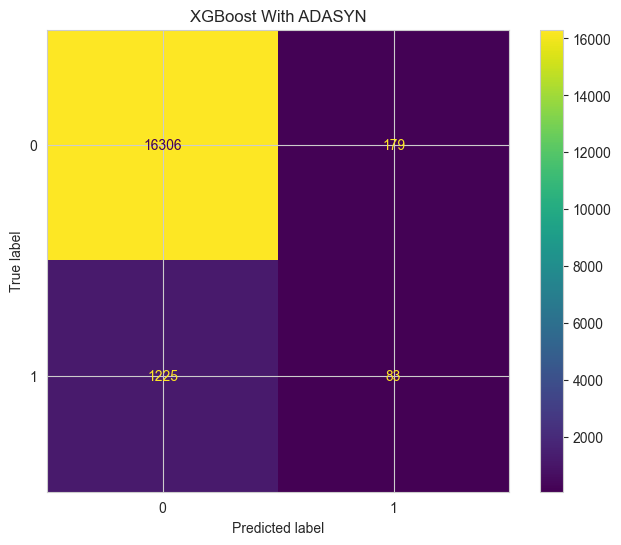

In [75]:
confusion_matrix = metrics.confusion_matrix(y_test, y_pred_XGB)
cm_display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=[0, 1])
cm_display.plot()
plt.title("XGBoost With ADASYN")
plt.show()

XGB with ADASYN-RFECV

In [83]:
from sklearn.metrics import average_precision_score

# Define hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'learning_rate': [0.01, 0.03, 0.5, 0.8, 1],
    'max_depth': [1, 10],
    'scale_pos_weight': [10, 12.5, 15]
}

XGB_ADASYN_RFECV = XGBClassifier(random_state=0, n_jobs=-1)
rfecv_XGB = RFECV(estimator=XGB_ADASYN_RFECV, step=1, cv=10, scoring='accuracy', n_jobs=-1)

# Create pipeline
pipeline = Pipeline([
    #('feature_selection', rfecv_XGB)
    ('classification', XGB_ADASYN_RFECV)
])

# Perform GridSearchCV
grid_search = GridSearchCV(
    estimator=XGB_ADASYN_RFECV,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Record start time
start_time = time.time()
# Print timing
print(f"Model training started at: {time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(start_time))}")

# Fit the model
grid_search.fit(X_res, y_res)

# Record end time
end_time = time.time()

print(f"Model training ended at: {time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(end_time))}")
print(f"Total Training Time: {end_time - start_time:.2f} seconds")

# Print the best parameters
print("Best Parameters: ", grid_search.best_params_)

# Evaluate performance on a test set
y_pred = grid_search.predict(X_test)
y_prob = grid_search.predict_proba(X_test)[:, 1]  

# Model performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)
pr_auc = average_precision_score(y_test, y_prob)
classification_report_str = classification_report(y_test, y_pred)
conf_matrix = metrics.confusion_matrix(y_test, y_pred)

# Print results
print("\nModel Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"MCC: {mcc:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"Precision-Recall AUC (PR AUC): {pr_auc:.4f}")
print("Classification Report:")
print(classification_report_str)
print("Confusion Matrix:")
print(conf_matrix)

Model training started at: 2024-11-26 19:38:43
Fitting 5 folds for each of 60 candidates, totalling 300 fits


Python(10991) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(10993) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(10994) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(10995) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(10997) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(10998) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(10999) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(11000) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Model training ended at: 2024-11-26 20:24:53
Total Training Time: 2769.78 seconds
Best Parameters:  {'learning_rate': 0.03, 'max_depth': 20, 'n_estimators': 200}

Model Performance:
Accuracy: 0.9238
Precision: 0.3182
Recall: 0.0321
F1 Score: 0.0583
MCC: 0.0811
ROC AUC: 0.7331
Precision-Recall AUC (PR AUC): 0.1863
Classification Report:
              precision    recall  f1-score   support

         0.0       0.93      0.99      0.96     16485
         1.0       0.32      0.03      0.06      1308

    accuracy                           0.92     17793
   macro avg       0.62      0.51      0.51     17793
weighted avg       0.88      0.92      0.89     17793

Confusion Matrix:
[[16395    90]
 [ 1266    42]]


In [69]:
XGB_ADASYN_RFECV = XGBClassifier(random_state=0, n_jobs=-1, learning_rate=0.8, max_depth=10, n_estimators=200)

In [70]:
rfecv_XGB = RFECV(estimator=XGB_ADASYN_RFECV, step=1, cv=10, scoring='accuracy', n_jobs=4)

In [71]:
rfecv_XGB.fit(X_res, y_res)

RFECV(cv=10,
      estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.8,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=10, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=200, n_jobs=-1,
                              num_parallel_tree=None, random_state=0, ...),
      n_jobs=4, scoring='accuracy')

In [57]:
print("Optimal Number of Features, XGB:", rfecv_XGB.n_features_)

Optimal Number of Features, XGB: 64


In [58]:
# Evaluate performance on a test set
y_pred_rfecv = rfecv_XGB.predict(X_test)
y_prob_rfecv = rfecv_XGB.predict_proba(X_test)[:, 1]  

# Model performance metrics
accuracy = accuracy_score(y_test, y_pred_rfecv)
precision = precision_score(y_test, y_pred_rfecv)
recall = recall_score(y_test, y_pred_rfecv)
f1 = f1_score(y_test, y_pred_rfecv)
mcc = matthews_corrcoef(y_test, y_pred_rfecv)
roc_auc = roc_auc_score(y_test, y_prob_rfecv)
pr_auc = average_precision_score(y_test, y_prob_rfecv)
classification_report_str = classification_report(y_test, y_pred_rfecv)
conf_matrix = confusion_matrix(y_test, y_pred_rfecv)

# Print results
print("\nModel Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"MCC: {mcc:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"Precision-Recall AUC (PR AUC): {pr_auc:.4f}")
print("Classification Report:")
print(classification_report_str)
print("Confusion Matrix:")
print(conf_matrix)


Model Performance:
Accuracy: 0.9224
Precision: 0.3460
Recall: 0.0627
F1 Score: 0.1061
MCC: 0.1213
ROC AUC: 0.7248
Precision-Recall AUC (PR AUC): 0.1897
Classification Report:
              precision    recall  f1-score   support

         0.0       0.93      0.99      0.96     16485
         1.0       0.35      0.06      0.11      1308

    accuracy                           0.92     17793
   macro avg       0.64      0.53      0.53     17793
weighted avg       0.89      0.92      0.90     17793

Confusion Matrix:
[[16330   155]
 [ 1226    82]]


Text(0.5, 1.0, 'XGB with ADASYN-RFECV')

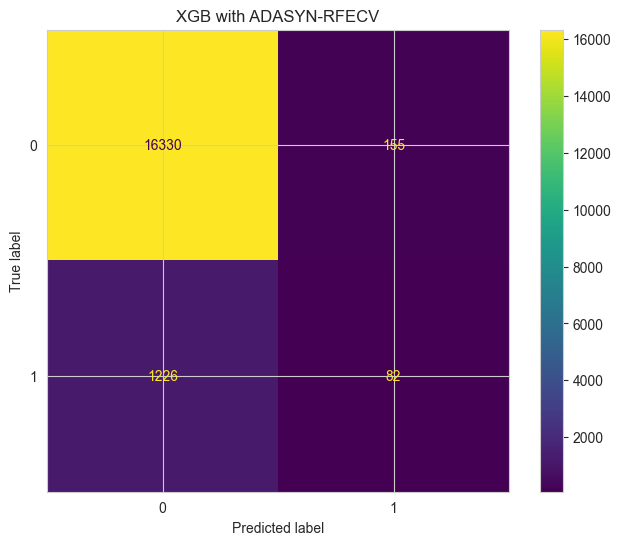

In [59]:
confusion_matrix = metrics.confusion_matrix(y_test, y_pred_rfecv)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])
cm_display.plot()
cm_display.ax_.set_title('XGB with ADASYN-RFECV')

In [52]:
cv = KFold(n_splits=10, random_state=0, shuffle=True)

y_pred_XGB = cross_val_predict(XGB, X_res, y_res, cv=cv)

In [60]:
print('...............')
print('XGB:')
accuracy = accuracy_score(y_test, y_pred_XGB)
print('Accuracy: %.4f' % accuracy)
precision = precision_score(y_test, y_pred_XGB)
print('Precision: %.4f' % precision)
recall = recall_score(y_test, y_pred_XGB)
print('Recall: %.4f' % recall)
f1 = f1_score(y_test, y_pred_XGB)
print('F1 score: %.4f' % f1)
MCC = matthews_corrcoef(y_test, y_pred_XGB)
print('MCC: %.4f' % (MCC))
roc_auc = roc_auc_score(y_test, y_pred_XGB)
print('roc_auc: %.4f' % (roc_auc))
pr_auc = average_precision_score(y_test, y_pred_XGB)
print('pr_auc: %.4f' % (pr_auc))
classification_report_str = classification_report(y_test, y_pred_XGB)
print(classification_report_str)

...............
XGB:
Accuracy: 0.9211
Precision: 0.3168
Recall: 0.0635
F1 score: 0.1057
MCC: 0.1140
roc_auc: 0.5263
pr_auc: 0.0889
              precision    recall  f1-score   support

         0.0       0.93      0.99      0.96     16485
         1.0       0.32      0.06      0.11      1308

    accuracy                           0.92     17793
   macro avg       0.62      0.53      0.53     17793
weighted avg       0.89      0.92      0.90     17793


XGB with SMOTE - RFECV

In [65]:
rfecv_XGB_SMOTE = RFECV(estimator=XGB, step=1, cv=10, scoring='accuracy', n_jobs=4)
#X_res_smote, y_res_smote

rfecv_XGB_SMOTE.fit(X_res_smote, y_res_smote)

RFECV(cv=10,
      estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=4,
                              num_parallel_tree=None, random_state=0, ...),
      n_jobs=4, scoring='accuracy')

In [72]:
print("Optimal Number of Features, XGB:", rfecv_XGB_SMOTE.n_features_)

Optimal Number of Features, XGB: 79


In [73]:
# Evaluate performance on a test set
y_pred_SMOTE = rfecv_XGB_SMOTE.predict(X_test)
y_prob_SMOTE = rfecv_XGB_SMOTE.predict_proba(X_test)[:, 1]  

# Model performance metrics
accuracy = accuracy_score(y_test, y_pred_SMOTE)
precision = precision_score(y_test, y_pred_SMOTE)
recall = recall_score(y_test, y_pred_SMOTE)
f1 = f1_score(y_test, y_pred_SMOTE)
mcc = matthews_corrcoef(y_test, y_pred_SMOTE)
roc_auc = roc_auc_score(y_test, y_prob_SMOTE)
pr_auc = average_precision_score(y_test, y_prob_SMOTE)
classification_report_str = classification_report(y_test, y_pred_SMOTE)

# Print results
print("\nModel Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"MCC: {mcc:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"Precision-Recall AUC (PR AUC): {pr_auc:.4f}")
print("Classification Report:")
print(classification_report_str)


Model Performance:
Accuracy: 0.9215
Precision: 0.3154
Recall: 0.0581
F1 Score: 0.0981
MCC: 0.1086
ROC AUC: 0.7207
Precision-Recall AUC (PR AUC): 0.1827
Classification Report:
              precision    recall  f1-score   support

         0.0       0.93      0.99      0.96     16485
         1.0       0.32      0.06      0.10      1308

    accuracy                           0.92     17793
   macro avg       0.62      0.52      0.53     17793
weighted avg       0.88      0.92      0.90     17793


Text(0.5, 1.0, 'XGB with SMOTE-RFECV')

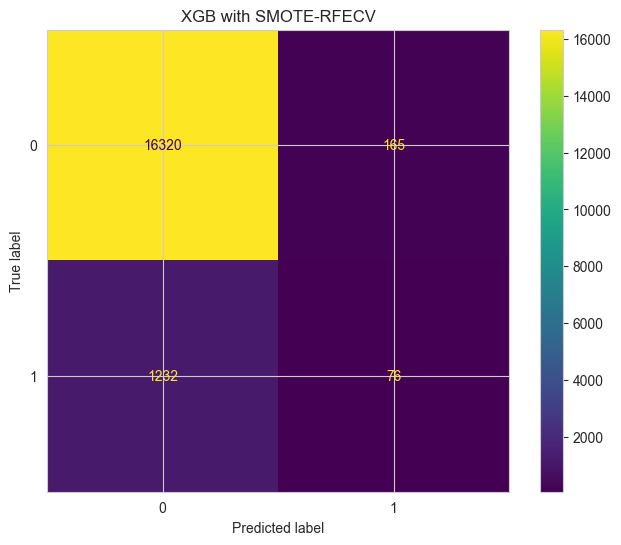

In [74]:
confusion_matrix = metrics.confusion_matrix(y_test, y_pred_SMOTE)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])
cm_display.plot()
cm_display.ax_.set_title('XGB with SMOTE-RFECV')

In [105]:
cv = KFold(n_splits=10, random_state=0, shuffle=True)

y_pred_XGB_smote = cross_val_predict(XGB, X_res_smote, y_res_smote, cv=cv)

In [108]:
print('...............')
print('XGB: SMOTE')
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_res_smote, y_pred_XGB_smote)
print('Accuracy: %.4f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_res_smote, y_pred_XGB_smote)
print('Precision: %.4f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_res_smote, y_pred_XGB_smote)
print('Recall: %.4f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_res_smote, y_pred_XGB_smote)
print('F1 score: %.4f' % f1)
MCC = matthews_corrcoef(y_res_smote, y_pred_XGB_smote)
print('MCC: %.4f' % (MCC))

...............
XGB: SMOTE
Accuracy: 0.9582
Precision: 0.9896
Recall: 0.9261
F1 score: 0.9568
MCC: 0.9183


In [62]:
from sklearn.inspection import permutation_importance
import numpy as np
import pandas as pd

# Function to generate counterfactual for a single instance
def generate_counterfactual(instance, model, feature_names, target_value, step=0.05, max_iter=100):
    """
    Generate a counterfactual for a given instance.
    Parameters:
    - instance: The original feature vector as a Pandas Series
    - model: Trained model
    - feature_names: List of feature names
    - target_value: Desired prediction value
    - step: Incremental step for feature adjustments
    - max_iter: Maximum number of iterations
    """
    counterfactual = instance.copy()
    original_prediction = model.predict([counterfactual.values])[0]

    if original_prediction == target_value:
        return counterfactual, 0  # Already the desired outcome

    for _ in range(max_iter):
        for feature in feature_names:
            # Adjust the feature slightly
            counterfactual[feature] += step * np.sign(target_value - original_prediction)
            prediction = model.predict([counterfactual.values])[0]
            
            if prediction == target_value:
                return counterfactual, _ + 1  # Return after finding a valid counterfactual

    return None, max_iter  # Return None if no counterfactual found within max_iter

In [63]:
feature_names = X_res.columns  # Assuming X_res is your feature set after ADASYN-RFECV
target_value = 0  # Desired target value

In [64]:
# Ensure predictions are for the test set only
y_pred_XGB_test = rfecv_XGB.predict(X_test_selected_XGB_df)

# Select misclassified instances
misclassified_indices = np.where(y_test != y_pred_XGB_test)[0]  # Get indices of misclassified samples
misclassified = X_test_selected_XGB_df.iloc[misclassified_indices]  # Subset the DataFrame

# Generate counterfactuals
counterfactuals = []

NameError: name 'X_test_selected_XGB_df' is not defined

In [157]:
misclassified = X_test_selected_XGB[(y_test != y_pred_XGB)]  # Select misclassified instances
counterfactuals = []

for idx, instance in misclassified.iterrows():
    cf, steps = generate_counterfactual(instance, XGB, feature_names, target_value)
    if cf is not None:
        counterfactuals.append((idx, cf, steps))

# Convert counterfactuals to DataFrame for analysis
counterfactuals_df = pd.DataFrame(counterfactuals, columns=['Index', 'Counterfactual', 'Steps'])

# Analyze or save the counterfactual results
print(counterfactuals_df)

ValueError: ('Lengths must match to compare', (17793,), (132324,))